# KNN classification on `Smarket`

This notebook loads the `Smarket` dataset via `ISLP.load_data('Smarket')` and fits a K-Nearest Neighbors (KNN) classifier to predict market `Direction`.

**Notes**
- If you don't have `ISLP` installed, run the installation cell below.
- We follow the classic ISLP/ISLR setup: train on years **2001–2004** and test on **2005**, using predictors `Lag1` and `Lag2`.


In [ ]:
# If needed, install ISLP (and scikit-learn)
# !pip -q install ISLP scikit-learn

In [1]:
import numpy as np
import pandas as pd
from ISLP import load_data
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

Smarket = load_data('Smarket')
Smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


## Train/test split
We train on observations with `Year < 2005` and test on `Year == 2005`.

In [2]:
train = Smarket['Year'] < 2005
test  = Smarket['Year'] == 2005

features = ['Lag1', 'Lag2']
X_train = Smarket.loc[train, features]
y_train = Smarket.loc[train, 'Direction']
X_test  = Smarket.loc[test, features]
y_test  = Smarket.loc[test, 'Direction']

X_train.shape, X_test.shape

((998, 2), (252, 2))

## Fit KNN
KNN is distance-based, so we **standardize** the predictors. We'll evaluate a few values of *k*.

In [3]:
def fit_eval_knn(k: int):
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    acc = accuracy_score(y_test, pred)
    return acc, pred

results = []
for k in [1, 3, 5, 10, 25, 50]:
    acc,  _ = fit_eval_knn(k)
    results.append({'k': k, 'test_accuracy': acc})

pd.DataFrame(results).sort_values('k')

,k,test_accuracy
0,1,0.500000
1,3,0.531746
2,5,0.484127
3,10,0.519841
4,25,0.488095
5,50,0.492063


## Optional: quick visualization of decision regions
Because we used only `Lag1` and `Lag2`, we can visualize the decision boundary in 2D.

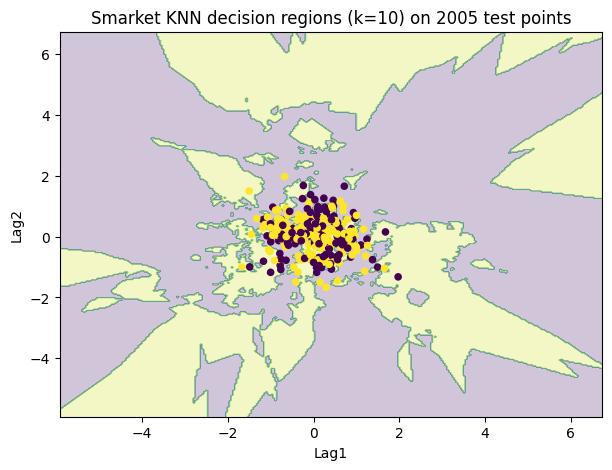

In [4]:
import matplotlib.pyplot as plt

k = 10  # try different k
model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=k))
])
model.fit(X_train, y_train)

# Grid
x_min, x_max = X_train['Lag1'].min() - 1, X_train['Lag1'].max() + 1
y_min, y_max = X_train['Lag2'].min() - 1, X_train['Lag2'].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300), np.linspace(y_min, y_max, 300))
grid = pd.DataFrame({'Lag1': xx.ravel(), 'Lag2': yy.ravel()})
Z = model.predict(grid).reshape(xx.shape)

plt.figure(figsize=(7, 5))
plt.contourf(xx, yy, (Z == 'Up').astype(int), alpha=0.25)
plt.scatter(X_test['Lag1'], X_test['Lag2'], c=(y_test == 'Up').astype(int), s=20)
plt.xlabel('Lag1')
plt.ylabel('Lag2')
plt.title(f'Smarket KNN decision regions (k={k}) on 2005 test points')
plt.show()